# Library

In [1]:
import itertools
import functools

import math

import numpy as np
import pandas as pd

import pyreadr

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

import umap
import umap.plot

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-14 13:34:48.840811: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data loading

In [2]:
clean_data = pyreadr.read_r('./data/absolute_dataset._clean_.RData')['absolute_dataset']
prot_matr_fc = pyreadr.read_r('./data/proteins.matrix.sva.0.5.1.FC.RData')['proteins.matrix.sva.0.5.1.FC']
prot_matr = pyreadr.read_r('./data/proteins.matrix.sva.0.5.1.RData')['proteins.matrix.sva.0.5.1']
orf2name = pyreadr.read_r('./data/orf2name._clean_.RData')['orf2name']
exp_metadata = pyreadr.read_r('./data/exp_metadata._clean_.RData')['exp_metadata']

# yeat metabolic model
imm904 = pyreadr.read_r('./data/iMM904._load_.RData')['iMM904']

metabolite_order = pd.read_csv('./data/metabolites.txt', delimiter='\t')
metabolie2imm904 = pyreadr.read_r('./data/metabolite2iMM904._load_.RData')['metabolite2iMM904']
gene_annotation = pyreadr.read_r('./data/gene.annotations._load_.RData')['gene.annotations']
go = pyreadr.read_r('./data/GO.raw._load_.RData')['GO.raw']

# brenda
brenda = pd.read_csv('./data/brenda.txt', delimiter='\t')

# metabolite data
tca_dataset = pyreadr.read_r('./data/dataTCA.create_datasets.RData')
aa_dataset = pyreadr.read_r('./data/dataAA.create_datasets.RData')

# models data
final_models_data = pyreadr.read_r('./data/all_final_models.models.data_prep.RData')['all_final_models.models']
prep_models_data = pyreadr.read_r('./data/all_linear_models.data_prep.RData')['all_linear_models']

# intervals
prediction_intervals = pyreadr.read_r('./data/prediction.intervals.data_prep.RData')['prediction.intervals']
prediction_models = pyreadr.read_r('./data/prediction.models.data_prep.RData')['prediction.models']

# raw
raw_metabolites = pd.read_csv('./data/metabolites_dataset.data_prep.tsv', delimiter='\t')
raw_proteins = pd.read_csv('./data/proteins_dataset.data_prep.tsv', delimiter='\t')

# Paper reproduction

In [22]:
all(raw_proteins[raw_proteins['KO_ORF'] == 'WT']['ORF'].unique() == raw_proteins[raw_proteins['KO_ORF'] == 'YPR111W']['ORF'].unique())

True

In [48]:
len(raw_metabolites[raw_metabolites['genotype'] == 'WT']['metabolite_id'].unique())

45

In [34]:
raw_proteins[raw_proteins['ORF'] == 'YGL253W']

,ORF,sample,replicate,KO_ORF,KO_gene_name,value
263,YGL253W,KL_Try_001_a,1,WT,WT,8.534627
989,YGL253W,KL_Try_001_b,2,WT,WT,8.578882
1715,YGL253W,KL_Try_001_c,3,WT,WT,8.618133
2441,YGL253W,KL_Try_003_a,1,YDR283C,GCN2,8.784255
3167,YGL253W,KL_Try_003_b,2,YDR283C,GCN2,8.827923
...,...,...,...,...,...,...
260897,YGL253W,KL_Try_99_a_1,2,YNL183C,NPR1,8.226027
261623,YGL253W,KL_Try_99_b,3,YNL183C,NPR1,8.298799
262349,YGL253W,KL_Try_99_b_1,4,YNL183C,NPR1,8.253239
263075,YGL253W,KL_Try_99_c,5,YNL183C,NPR1,8.100552


In [31]:
prot_matr_fc[prot_matr_fc['KO'] == 'YGL253W']

,ORF,contrasts,logFC,p.value,p.value_BH,p.value_bonferroni,KO,reference


In [41]:
len(raw_metabolites['official_name'].unique())

50

## Figure 2 reproduction

In [35]:
prot_matr_fc = prot_matr_fc[
    (prot_matr_fc['KO'].isin(exp_metadata[exp_metadata['type'] == 'Kinase']['ORF'].unique())) &
    (prot_matr_fc['ORF']).isin(imm904['gene']) &
    (prot_matr_fc['p.value_BH']  < 0.01) &
    (abs(prot_matr_fc['logFC']) > math.log2(1.4/0.714))
]

prot_matr_fc = prot_matr_fc.merge(orf2name[['ORF', 'gene_name']], left_on='KO', right_on='ORF', suffixes=(None, '_right'))

# prot_matr_fc[prot_matr_fc['gene_name'] == 'KDX1']
prot_matr_fc

,ORF,contrasts,logFC,p.value,p.value_BH,p.value_bonferroni,KO,reference,ORF_right,gene_name
0,YAL038W,YER129W-WT,-1.165160,1.157484e-40,8.151235e-38,8.151235e-36,YER129W,WT,YER129W,SAK1
1,YBR115C,YER129W-WT,-1.447165,2.172409e-04,9.925094e-04,1.000000e+00,YER129W,WT,YER129W,SAK1
2,YBR221C,YER129W-WT,-1.034736,8.353716e-22,7.087776e-20,5.882854e-17,YER129W,WT,YER129W,SAK1
3,YGL008C,YER129W-WT,-1.270291,7.553802e-12,1.502270e-10,5.319538e-07,YER129W,WT,YER129W,SAK1
4,YGR208W,YER129W-WT,1.038642,3.616926e-05,2.012095e-04,1.000000e+00,YER129W,WT,YER129W,SAK1
...,...,...,...,...,...,...,...,...,...,...
1225,YGR192C,YLL019C-WT,-1.275514,1.077783e-04,5.323677e-04,1.000000e+00,YLL019C,WT,YLL019C,KNS1
1226,YJL153C,YLL019C-WT,-1.156183,7.472814e-15,2.334740e-13,5.262505e-10,YLL019C,WT,YLL019C,KNS1
1227,YKL181W,YAL017W-WT,0.984922,3.133475e-04,1.369148e-03,1.000000e+00,YAL017W,WT,YAL017W,PSK1
1228,YMR105C,YNR047W-WT,-1.200005,6.078813e-10,8.855651e-09,4.280822e-05,YNR047W,WT,YNR047W,FPK1


In [36]:
upr_genes = prot_matr_fc[prot_matr_fc['logFC'] > 0]
downr_genes = prot_matr_fc[prot_matr_fc['logFC'] < 0]

wide_full = prot_matr_fc.pivot_table(index=['KO', 'gene_name'], columns='ORF', values='logFC').fillna(0).sort_values(by=['gene_name'])
wide_full[wide_full != 0] = 1

wide_upr = upr_genes.pivot_table(index=['KO', 'gene_name'], columns='ORF', values='logFC').fillna(0).sort_values(by=['gene_name'])
wide_upr[wide_upr != 0] = 1

wide_downr = downr_genes.pivot_table(index=['KO', 'gene_name'], columns='ORF', values='logFC').fillna(0).sort_values(by=['gene_name'])
wide_downr[wide_downr != 0] = 1

wide_upr

,ORF,YAL044C,YBL064C,YBR035C,YBR205W,YCL009C,YCL050C,YCR005C,YDL100C,YDR074W,YDR098C,...,YLR438W,YML022W,YMR215W,YMR300C,YOL030W,YOR095C,YPL262W,YPR035W,YPR062W,YPR145W
KO,gene_name,,,,,,,,,,,,,,,,,,,,,
YBR059C,AKL1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
YGL021W,ALK1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YNL020C,ARK1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YJL095W,BCK1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YGR188C,BUB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YHR135C,YCK1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YNL154C,YCK2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YOL128C,YGK3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
wide_index = wide_full.index.get_level_values('gene_name')
upr_index = wide_upr.index.get_level_values('gene_name')
downr_index = wide_downr.index.get_level_values('gene_name')

In [38]:
metric = 'jaccard'

wide_full_dist = 1 - squareform(pdist(wide_full.values, metric=metric))
wide_upr_dist = 1 - squareform(pdist(wide_upr.values, metric=metric))
wide_downr_dist = 1 - squareform(pdist(wide_downr.values, metric=metric))

print(f'{wide_full_dist.shape=} \n{wide_upr_dist.shape=} \n{wide_downr_dist.shape=}')

proj_wide_upr_dist = np.zeros(wide_full_dist.shape)
mask = np.array(np.where(np.in1d(wide_index, upr_index))[0])
proj_wide_upr_dist[mask[:, np.newaxis], mask] = wide_upr_dist

proj_wide_downr_dist = np.zeros(wide_full_dist.shape)
mask = np.array(np.where(np.in1d(wide_index, downr_index))[0])
proj_wide_downr_dist[mask[:, np.newaxis], mask] = wide_downr_dist

zeros = np.zeros(shape=wide_full_dist.shape)
zeros[np.logical_not(np.tri(*zeros.shape, dtype=np.bool_))] = proj_wide_upr_dist[np.logical_not(np.tri(*zeros.shape, dtype=np.bool_))]
zeros[np.tri(*zeros.shape, dtype=np.bool_)] = proj_wide_downr_dist[np.tri(*zeros.shape, dtype=np.bool_)] * -1

wide_full_dist.shape=(94, 94) 
wide_upr_dist.shape=(79, 79) 
wide_downr_dist.shape=(93, 93)


[[0.01960784 0.18823529 0.38039216 1.        ]
 [0.18431373 0.47266436 0.71164937 1.        ]
 [0.51787774 0.73794694 0.85190311 1.        ]
 [0.86051519 0.91741638 0.94871203 1.        ]
 [0.98477509 0.89327182 0.83944637 1.        ]
 [0.94071511 0.60991926 0.48127643 1.        ]
 [0.76170704 0.22145329 0.22875817 1.        ]
 [0.40392157 0.         0.12156863 1.        ]]
[[0.01960784 0.18823529 0.38039216 1.        ]
 [0.18431373 0.47266436 0.71164937 1.        ]
 [0.51787774 0.73794694 0.85190311 1.        ]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [0.94071511 0.60991926 0.48127643 1.        ]
 [0.76170704 0.22145329 0.22875817 1.        ]
 [0.40392157 0.         0.12156863 1.        ]]


<AxesSubplot:>

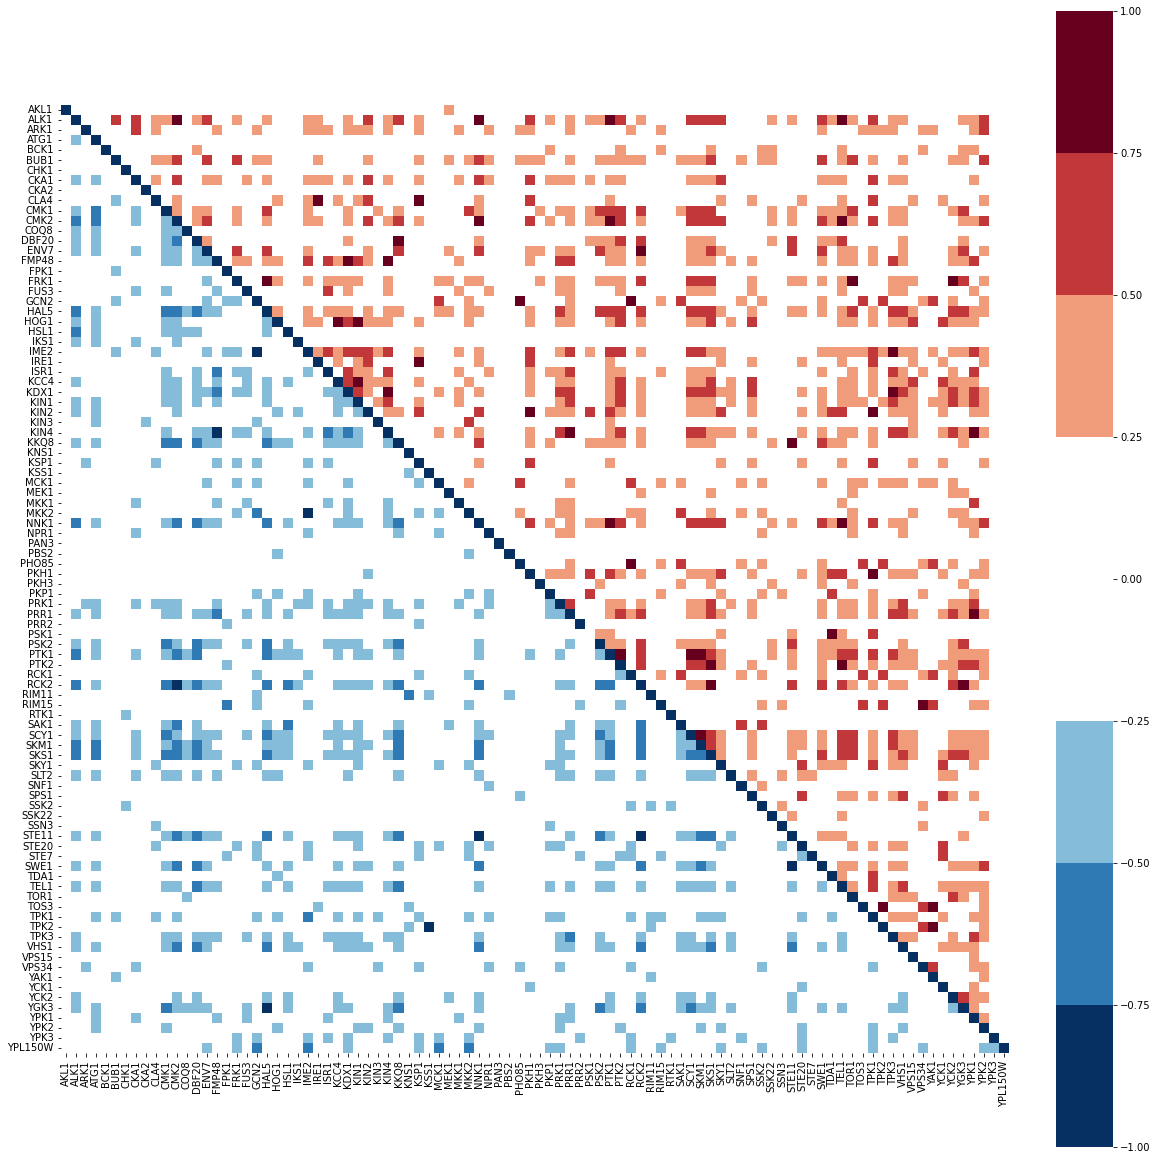

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16), constrained_layout=True)

bounds = np.linspace(-1, 1, 9)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

cmap = cm.get_cmap('RdBu_r', 256)
cmap = cmap(norm(bounds[:-1]))
print(cmap)
cmap[3] = [1,1,1,1]
cmap[4] = [1,1,1,1]
# print(cmap(norm.boundaries))
print(cmap)

colors.ListedColormap(cmap)

sns.heatmap(
    zeros,
    cbar=True,
    ax=ax,
    square=True,
    cmap=colors.ListedColormap(cmap),
    # norm=norm,
    xticklabels=wide_full.index.get_level_values('gene_name').tolist(),
    yticklabels=wide_full.index.get_level_values('gene_name').tolist()
)

# pcm = ax.pcolor(zeros, norm=norm, cmap='RdBu_r')
# # The colorbar inherits the "extend" argument from BoundaryNorm.
# fig.colorbar(pcm, ax=ax, orientation='vertical')
# ax.set_title('BoundaryNorm: extend="both"')
# plt.show()

## Figure 4 reporduction

In [9]:
metabolite_order

,met_name,metabolite,pathway,method,Order
0,L-Phenylalanine,phenylalanine,Aromatic family,AA,0
1,L-Tryptophan,tryptophan,Aromatic family,AA,0
2,L-Tyrosine,tyrosine,Aromatic family,AA,0
3,L-Asparagine,asparagine,Aspartate family,AA,0
4,L-Aspartate,aspartate,Aspartate family,AA,0
5,L-Threonine,threonine,Aspartate family,AA,0
6,L-Arginine,arginine,Glutamate family,AA,0
7,L-Glutamate,glutamate,Glutamate family,AA,0
8,L-Glutamine,glutamine,Glutamate family,AA,0
9,L-Lysine,lysine,Glutamate family,AA,0


In [10]:
metabolite_order[['metabolite', 'pathway']]

,metabolite,pathway
0,phenylalanine,Aromatic family
1,tryptophan,Aromatic family
2,tyrosine,Aromatic family
3,asparagine,Aspartate family
4,aspartate,Aspartate family
5,threonine,Aspartate family
6,arginine,Glutamate family
7,glutamate,Glutamate family
8,glutamine,Glutamate family
9,lysine,Glutamate family


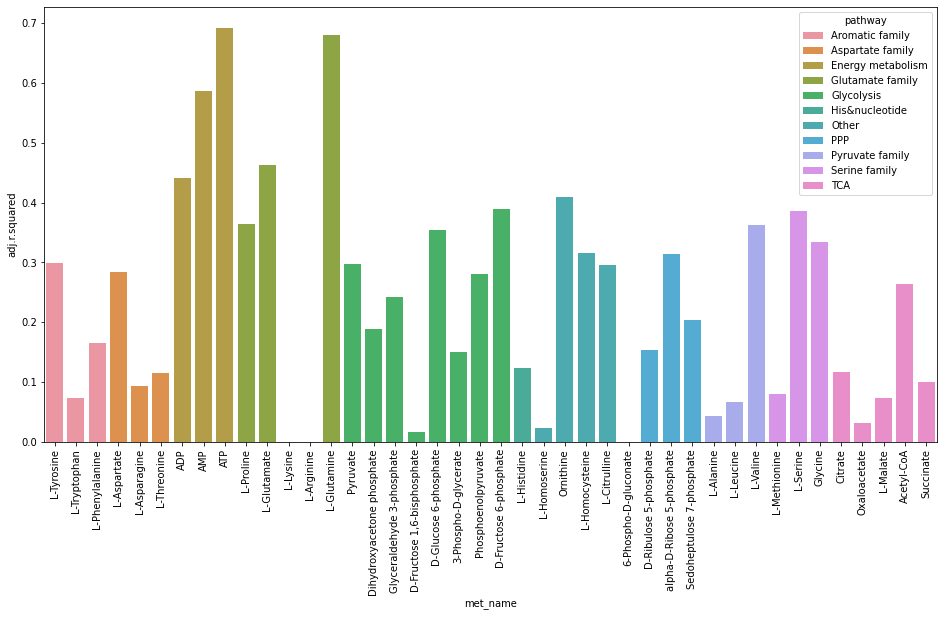

In [11]:
df = final_models_data[
    (final_models_data['metabolite']).isin(metabolite_order['metabolite']) &
    (final_models_data['degree'] == "1") &
    (final_models_data['ismetIncluded'] == "0") & 
    (final_models_data['the_super_best'] == True) &
    (final_models_data['isImputed'] == 0.0) &
    (final_models_data['isAutocorrelation.bonferoni'] == 0.0)
]

df = df[['metabolite', 'adj.r.squared']].drop_duplicates()
df = df.merge(metabolite_order[['metabolite', 'pathway', 'met_name']], on='metabolite')

df = df.sort_values('pathway')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

g = sns.barplot(
    x='met_name',
    y='adj.r.squared',
    hue='pathway',
    # order='pathway',
    data=df,
    ax=ax,
    dodge=False,
    ci=None
)

plt.xticks(rotation=90)

g.set(ylim=(0, None))

plt.show()

# Project

In [76]:
# first we transform the data to categories
to_categorical = {
    'metabolite_id': 'category',
    'kegg_id': 'category',
    'official_name': 'category',
    'genotype': 'category',
}

metabolites_df = raw_metabolites.fillna('Unknown')
metabolites_df = metabolites_df.astype(to_categorical)
metabolites_df = metabolites_df.merge(metabolite_order[['met_name', 'pathway']], left_on='official_name', right_on='met_name', how='left')
metabolites_df['pathway'] = metabolites_df['pathway'].fillna('Unknown')
metabolites_df['met_name'] = metabolites_df['met_name'].fillna('Unknown')
metabolites_df = metabolites_df.sort_values(by='pathway')

metabolites_df.describe(include='all')

,metabolite_id,kegg_id,official_name,dataset,genotype,replicate,value,met_name,pathway
count,3522,3522,3522,3522.000000,3522,3522.000000,3522.000000,3522,3522
unique,50,50,50,NaN,96,NaN,NaN,42,12
top,3pg;2pg,C00111,6-Phospho-D-gluconate,NaN,YPL140C,NaN,NaN,Unknown,Glycolysis
freq,148,148,148,NaN,145,NaN,NaN,691,883
mean,NaN,NaN,NaN,1.857183,NaN,1.533220,2702.901412,NaN,NaN
std,NaN,NaN,NaN,0.819938,NaN,0.767231,5975.218172,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,1.000000,0.004140,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.000000,10.704988,NaN,NaN
50%,NaN,NaN,NaN,2.000000,NaN,1.000000,92.916859,NaN,NaN
75%,NaN,NaN,NaN,3.000000,NaN,2.000000,891.112487,NaN,NaN


In [77]:
metabolites_df

,metabolite_id,kegg_id,official_name,dataset,genotype,replicate,value,met_name,pathway
3431,trp-L,C00078,L-Tryptophan,3,YPL141C,1,0.424480,L-Tryptophan,Aromatic family
3414,trp-L,C00078,L-Tryptophan,3,YHR079C,3,0.371426,L-Tryptophan,Aromatic family
3415,trp-L,C00078,L-Tryptophan,3,YHR082C,1,0.326815,L-Tryptophan,Aromatic family
3416,trp-L,C00078,L-Tryptophan,3,YHR082C,2,0.340360,L-Tryptophan,Aromatic family
3417,trp-L,C00078,L-Tryptophan,3,YHR082C,3,0.315160,L-Tryptophan,Aromatic family
...,...,...,...,...,...,...,...,...,...
960,glc-D,C00031,D-Glucose,1,YIL095W,1,14862.885793,Unknown,Unknown
959,glc-D,C00031,D-Glucose,1,YIL042C,1,18332.892252,Unknown,Unknown
958,glc-D,C00031,D-Glucose,1,YIL035C,1,13004.592505,Unknown,Unknown
967,glc-D,C00031,D-Glucose,1,YJL165C,1,19089.001739,Unknown,Unknown


In [13]:
# first we transform the data to categories
to_categorical = {
    'ORF': 'category',
    'sample': 'category',
    'KO_ORF': 'category',
    'KO_gene_name': 'category',
}

proteins_df = raw_proteins.astype(to_categorical)

proteins_df.describe(include='all')

,ORF,sample,replicate,KO_ORF,KO_gene_name,value
count,264264,264264,264264.000000,264264,264264,264264.000000
unique,726,364,NaN,98,98,NaN
top,YAL003W,KL_Try_001_a,NaN,WT,WT,NaN
freq,364,726,NaN,8712,8712,NaN
mean,NaN,NaN,2.681319,NaN,NaN,6.307523
std,NaN,NaN,1.715345,NaN,NaN,1.418793
min,NaN,NaN,1.000000,NaN,NaN,0.891259
25%,NaN,NaN,1.000000,NaN,NaN,5.328361
50%,NaN,NaN,2.000000,NaN,NaN,6.264424
75%,NaN,NaN,3.000000,NaN,NaN,7.263535


In [14]:
proteins_df[
    (~proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
]

,ORF,sample,replicate,KO_ORF,KO_gene_name,value
10890,YAL003W,KL_Try_007_a,1,YLR240W,VPS34,8.469039
10891,YAL005C,KL_Try_007_a,1,YLR240W,VPS34,8.738073
10892,YAL007C,KL_Try_007_a,1,YLR240W,VPS34,4.967732
10893,YAL012W,KL_Try_007_a,1,YLR240W,VPS34,8.474297
10894,YAL035W,KL_Try_007_a,1,YLR240W,VPS34,4.935572
...,...,...,...,...,...,...
236671,YPR165W,KL_Try_13_c_1,3,YPL031C,PHO85,7.028272
236672,YPR181C,KL_Try_13_c_1,3,YPL031C,PHO85,5.674753
236673,YPR183W,KL_Try_13_c_1,3,YPL031C,PHO85,7.094970
236674,YPR187W,KL_Try_13_c_1,3,YPL031C,PHO85,3.632241


In [15]:
metabolites_df[
    metabolites_df['official_name'].isin(metabolite_order['met_name'])
]

,metabolite_id,kegg_id,official_name,dataset,genotype,replicate,value,met_name,pathway
3431,trp-L,C00078,L-Tryptophan,3,YPL141C,1,0.424480,L-Tryptophan,Aromatic family
3414,trp-L,C00078,L-Tryptophan,3,YHR079C,3,0.371426,L-Tryptophan,Aromatic family
3415,trp-L,C00078,L-Tryptophan,3,YHR082C,1,0.326815,L-Tryptophan,Aromatic family
3416,trp-L,C00078,L-Tryptophan,3,YHR082C,2,0.340360,L-Tryptophan,Aromatic family
3417,trp-L,C00078,L-Tryptophan,3,YHR082C,3,0.315160,L-Tryptophan,Aromatic family
...,...,...,...,...,...,...,...,...,...
2645,cit,C00158,Citrate,2,YDR477W,2,34.506523,Citrate,TCA
2644,cit,C00158,Citrate,2,YDR477W,1,29.576093,Citrate,TCA
2654,cit,C00158,Citrate,2,YHL007C,3,13.566058,Citrate,TCA
2393,akg,C00026,2-Oxoglutarate,2,WT,1,10.377185,2-Oxoglutarate,TCA


In [16]:
metabolites_df.describe(include='all')

,metabolite_id,kegg_id,official_name,dataset,genotype,replicate,value,met_name,pathway
count,3522,3522,3522,3522.000000,3522,3522.000000,3522.000000,2831,3522
unique,50,50,50,NaN,96,NaN,NaN,41,12
top,3pg;2pg,C00111,6-Phospho-D-gluconate,NaN,YPL140C,NaN,NaN,Sedoheptulose 7-phosphate,Glycolysis
freq,148,148,148,NaN,145,NaN,NaN,148,883
mean,NaN,NaN,NaN,1.857183,NaN,1.533220,2702.901412,NaN,NaN
std,NaN,NaN,NaN,0.819938,NaN,0.767231,5975.218172,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,1.000000,0.004140,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.000000,10.704988,NaN,NaN
50%,NaN,NaN,NaN,2.000000,NaN,1.000000,92.916859,NaN,NaN
75%,NaN,NaN,NaN,3.000000,NaN,2.000000,891.112487,NaN,NaN


## Exploratory analysis

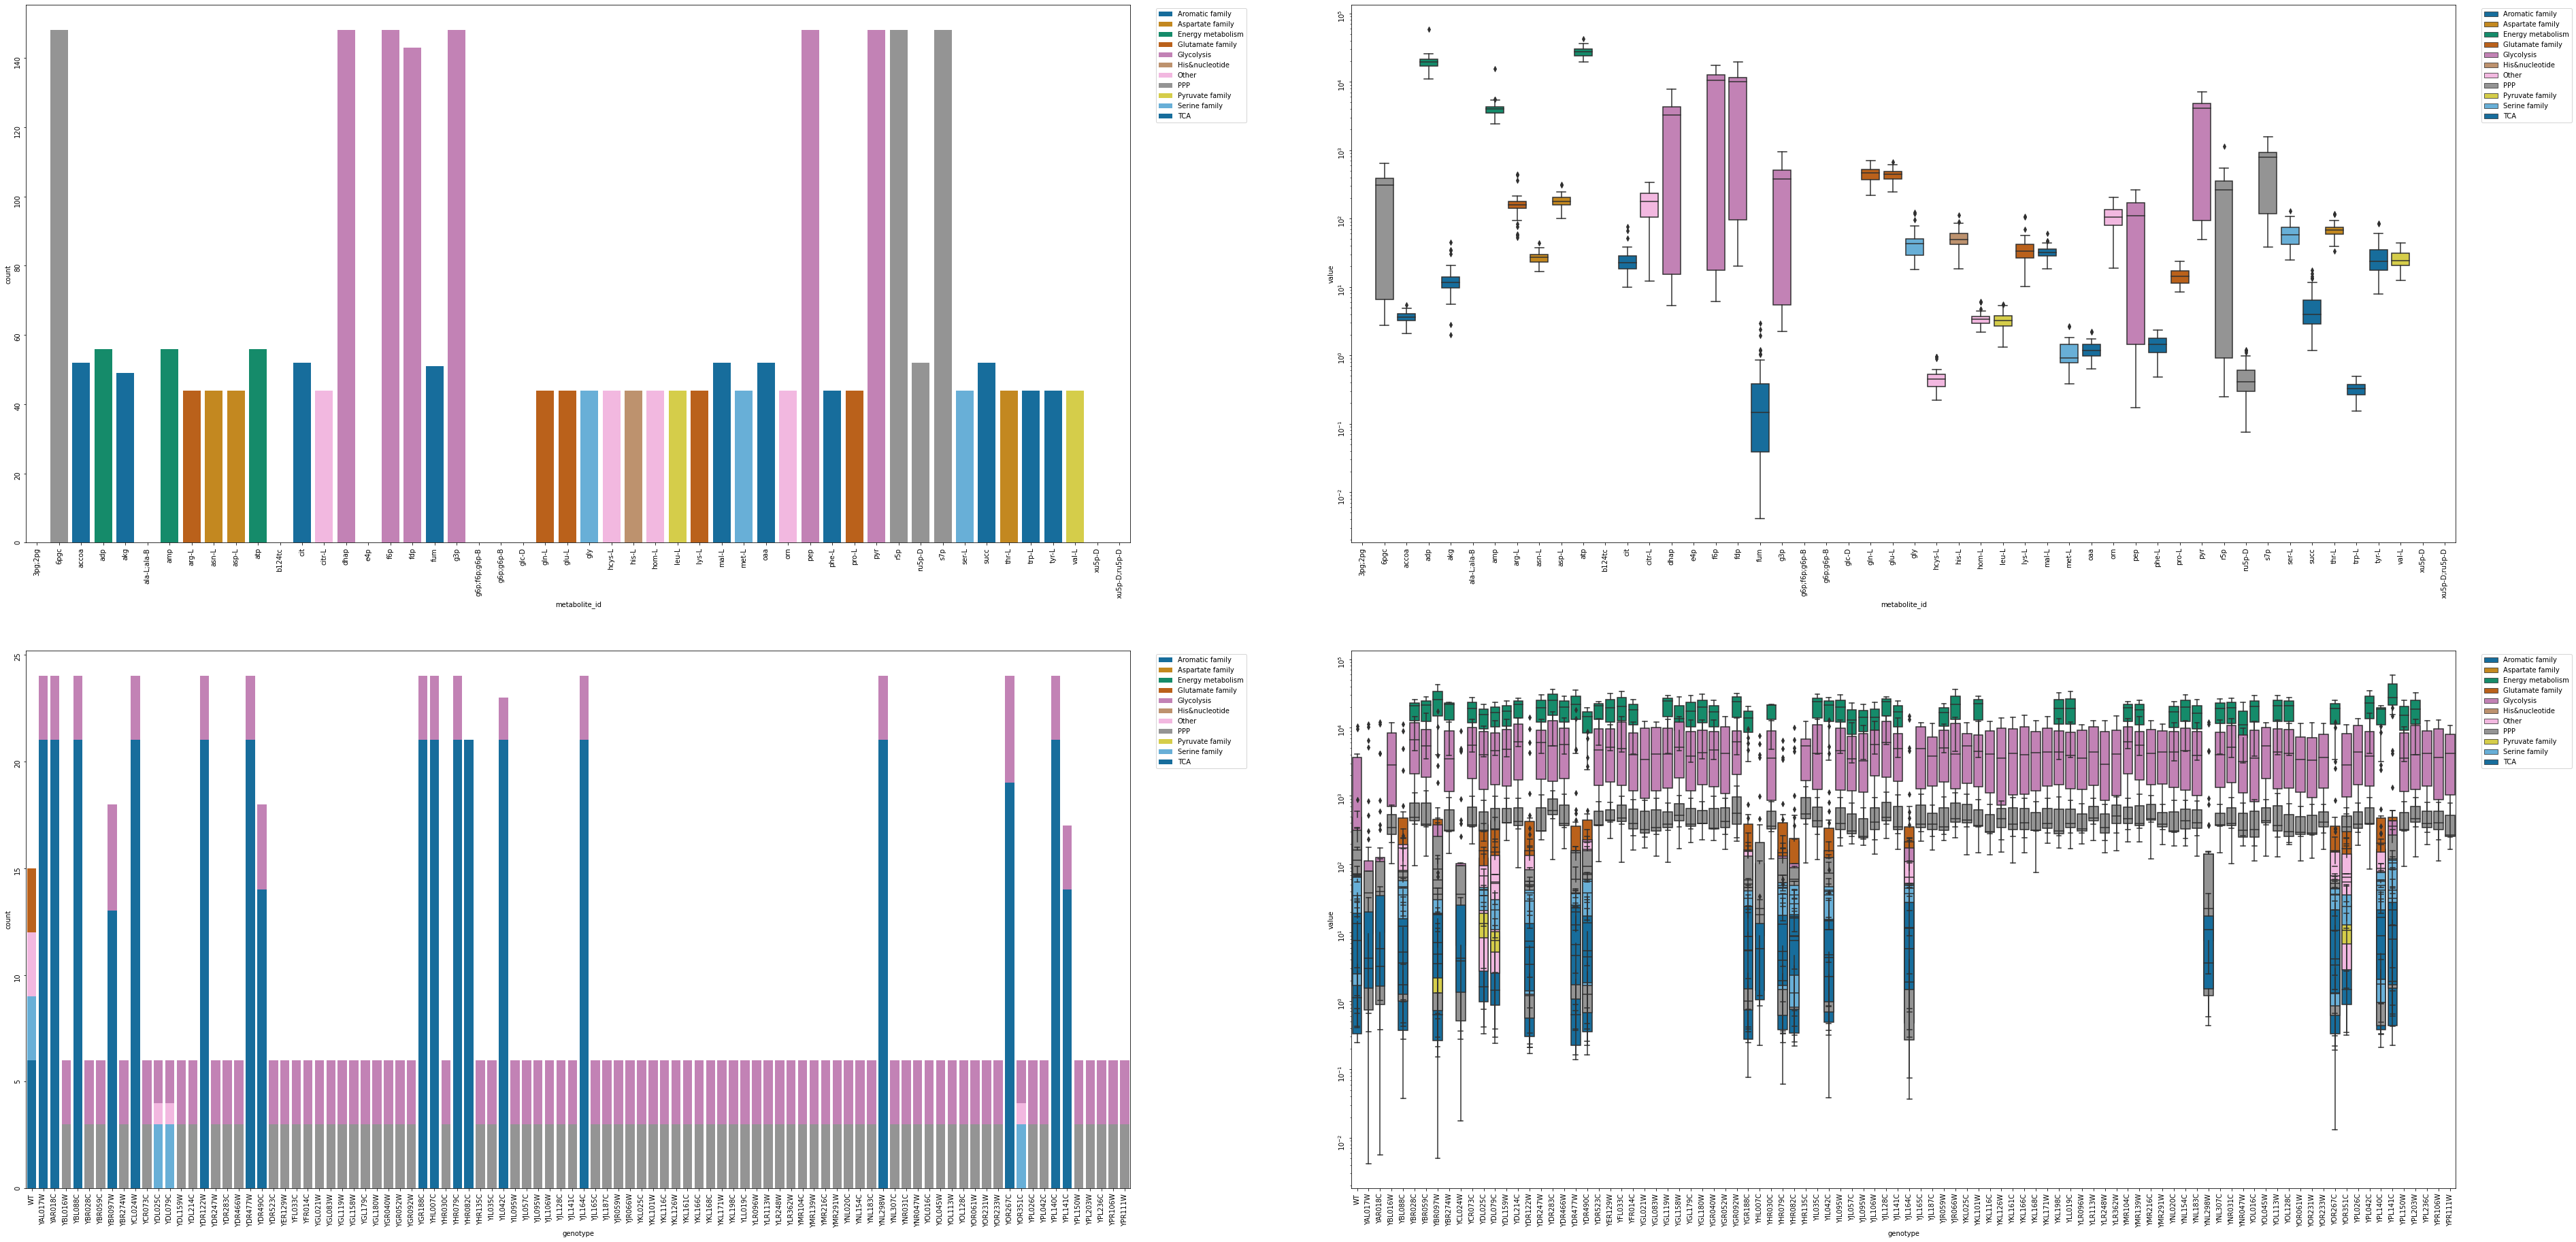

In [17]:
# we visualize some very simple statistics of the dataset
# we start by analysing the metabolites data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(64, 32))

df = metabolites_df[metabolites_df['pathway'] != 'Unknown']

g = sns.countplot(
    x='metabolite_id',
    # y='adj.r.squared',
    hue='pathway',
    # order='pathway',
    data=df,
    ax=ax1,
    dodge=False,
    palette='colorblind',
    # order=df['pathway'].value_counts().index[::-1]
)

ax1.tick_params(labelrotation=90)
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

sns.boxplot(
    x='metabolite_id',
    y='value',
    hue='pathway',
    data=df,
    ax=ax2,
    dodge=False,
    palette='colorblind',
)

ax2.tick_params(labelrotation=90)
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.set_yscale('log')

sns.countplot(
    x='genotype',
    hue='pathway',
    data=df,
    ax=ax3,
    dodge=False,
    palette='colorblind'
)

ax3.tick_params(labelrotation=90)
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

sns.boxplot(
    x='genotype',
    y='value',
    hue='pathway',
    data=df,
    ax=ax4,
    dodge=False,
    palette='colorblind',
)

ax4.tick_params(labelrotation=90)
ax4.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax4.set_yscale('log')

plt.show()

In [18]:
proteins_df

,ORF,sample,replicate,KO_ORF,KO_gene_name,value
0,YAL003W,KL_Try_001_a,1,WT,WT,8.778819
1,YAL005C,KL_Try_001_a,1,WT,WT,9.132257
2,YAL007C,KL_Try_001_a,1,WT,WT,5.188600
3,YAL012W,KL_Try_001_a,1,WT,WT,8.822701
4,YAL035W,KL_Try_001_a,1,WT,WT,4.919708
...,...,...,...,...,...,...
264259,YPR165W,KL_Try_99_c_1,6,YNL183C,NPR1,6.789486
264260,YPR181C,KL_Try_99_c_1,6,YNL183C,NPR1,6.055757
264261,YPR183W,KL_Try_99_c_1,6,YNL183C,NPR1,7.347029
264262,YPR187W,KL_Try_99_c_1,6,YNL183C,NPR1,4.298411


In [ ]:
mean_expression_per_knockout = proteins_df[
    (proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
] \
    .groupby(['KO_gene_name', 'ORF'])['value'].mean() \
    .to_frame().pivot_table(index='ORF', columns='KO_gene_name', values='value')

sns.pairplot(
    data=mean_expression_per_knockout,
    diag_kind='kde'
)
    

In [28]:
metabolites_df

,metabolite_id,kegg_id,official_name,dataset,genotype,replicate,value,met_name,pathway
3431,trp-L,C00078,L-Tryptophan,3,YPL141C,1,0.424480,L-Tryptophan,Aromatic family
3414,trp-L,C00078,L-Tryptophan,3,YHR079C,3,0.371426,L-Tryptophan,Aromatic family
3415,trp-L,C00078,L-Tryptophan,3,YHR082C,1,0.326815,L-Tryptophan,Aromatic family
3416,trp-L,C00078,L-Tryptophan,3,YHR082C,2,0.340360,L-Tryptophan,Aromatic family
3417,trp-L,C00078,L-Tryptophan,3,YHR082C,3,0.315160,L-Tryptophan,Aromatic family
...,...,...,...,...,...,...,...,...,...
960,glc-D,C00031,D-Glucose,1,YIL095W,1,14862.885793,NaN,Unknown
959,glc-D,C00031,D-Glucose,1,YIL042C,1,18332.892252,NaN,Unknown
958,glc-D,C00031,D-Glucose,1,YIL035C,1,13004.592505,NaN,Unknown
967,glc-D,C00031,D-Glucose,1,YJL165C,1,19089.001739,NaN,Unknown


In [62]:
metabolites_df.groupby('genotype')['met_name'].value_counts()

genotype  met_name                  
WT        Glycine                       3
          L-Arginine                    3
          L-Asparagine                  3
          L-Aspartate                   3
          L-Citrulline                  3
                                       ..
YPR111W   Glyceraldehyde 3-phosphate    1
          Phosphoenolpyruvate           1
          Pyruvate                      1
          Sedoheptulose 7-phosphate     1
          alpha-D-Ribose 5-phosphate    1
Name: met_name, Length: 1540, dtype: int64

In [64]:
a = proteins_df[
    (proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
] \
    .merge(metabolites_df[['genotype', 'met_name', 'pathway']], left_on='KO_ORF', right_on='genotype', how='inner') \
    .groupby(['KO_ORF', 'ORF'])['value'].mean() \
    .to_frame() 
b = metabolites_df.groupby('genotype')['met_name'].value_counts().index.get_level_values(1).to_frame()
# pd.concat([a, b], ignore_index=True, axis=1)
    # .pivot_table(index=['pathway', 'met_name'], columns='genotype', values='value')

# proteins_df[
#     (proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
# ] \
#     .groupby(['KO_ORF', 'ORF'])['value'].mean() \
#     .to_frame().pivot_table(index='ORF', columns='KO_ORF', values='value') 
    # .merge(metabolites_df[['genotype', 'met_name', 'pathway']], left_on='KO_ORF', right_on='genotype')

In [94]:
mean_expression_per_knockout = proteins_df[
    (proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
] \
    .merge(metabolites_df[['genotype', 'met_name', 'pathway']], left_on='KO_ORF', right_on='genotype', how='inner') \
    .query("met_name != 'Unknown'") \
    .groupby(['pathway', 'KO_ORF', 'ORF'])['value'].mean() \
    .to_frame() \
    .pivot_table(index=['KO_ORF', 'ORF'], columns='pathway', values='value') \
    .fillna(0)
    

In [95]:
mean_expression_per_knockout

pathway          Aromatic family  Aspartate family  Energy metabolism  \
KO_ORF  ORF                                                             
WT      YAL003W         8.673124          8.673124                0.0   
        YAL005C         8.943694          8.943694                0.0   
        YAL007C         5.021576          5.021576                0.0   
        YAL012W         8.747461          8.747461                0.0   
        YAL035W         5.392658          5.392658                0.0   
...                          ...               ...                ...   
YPR111W YPR165W         0.000000          0.000000                0.0   
        YPR181C         0.000000          0.000000                0.0   
        YPR183W         0.000000          0.000000                0.0   
        YPR187W         0.000000          0.000000                0.0   
        YPR191W         0.000000          0.000000                0.0   

pathway          Glutamate family  Glycolysis  His&nucleotide     Other  \
KO_ORF  ORF                                                               
WT      YAL003W          8.673124    8.673124        8.673124  8.673124   
        YAL005C          8.943694    8.943694        8.943694  8.943694   
        YAL007C          5.021576    5.021576        5.021576  5.021576   
        YAL012W          8.747461    8.747461        8.747461  8.747461   
        YAL035W          5.392658    5.392658        5.392658  5.392658   
...                           ...         ...             ...       ...   
YPR111W YPR165W          0.000000    7.042098        0.000000  0.000000   
        YPR181C          0.000000    5.665398        0.000000  0.000000   
        YPR183W          0.000000    7.348864        0.000000  0.000000   
        YPR187W          0.000000    4.289903        0.000000  0.000000   
        YPR191W          0.000000    7.441776        0.000000  0.000000   

pathway               PPP  Pyruvate family  Serine family       TCA  
KO_ORF  ORF                                                          
WT      YAL003W  8.673124         8.673124       8.673124  8.673124  
        YAL005C  8.943694         8.943694       8.943694  8.943694  
        YAL007C  5.021576         5.021576       5.021576  5.021576  
        YAL012W  8.747461         8.747461       8.747461  8.747461  
        YAL035W  5.392658         5.392658       5.392658  5.392658  
...                   ...              ...            ...       ...  
YPR111W YPR165W  7.042098         0.000000       0.000000  0.000000  
        YPR181C  5.665398         0.000000       0.000000  0.000000  
        YPR183W  7.348864         0.000000       0.000000  0.000000  
        YPR187W  4.289903         0.000000       0.000000  0.000000  
        YPR191W  7.441776         0.000000       0.000000  0.000000  

[69696 rows x 11 columns]

In [ ]:
reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    metric='correlation'
)
scaler = StandardScaler()

scaled_expression = scaler.fit_transform(mean_expression_per_knockout.values)
embedding = reducer.fit_transform(scaled_expression)



In [ ]:
umap.plot.points(
    reducer,
    mean_expression_per_knockout.index.get_level_values(0)
)

ORF,YAL003W,YAL005C,YAL007C,YAL012W,YAL035W,YAL038W,YAL042W,YAL044C,YAR002C-A,YAR007C,...,YPR129W,YPR133C,YPR145W,YPR160W,YPR163C,YPR165W,YPR181C,YPR183W,YPR187W,YPR191W
KO_ORF,,,,,,,,,,,,,,,,,,,,,
YAL017W,-0.001724,-0.015140,0.033160,-0.011294,-0.021731,0.005452,-0.393861,0.022055,-0.045587,0.027340,...,-0.009357,-0.070945,0.046128,-0.055521,-0.000251,-0.046093,-0.013831,-0.024727,0.075281,-0.044966
YAR018C,0.017790,-0.061848,-0.005416,-0.040603,0.050090,0.018108,0.044935,0.083723,-0.013278,0.014316,...,0.045891,-0.014725,0.044635,-0.070358,-0.074966,0.005675,0.006765,0.004706,0.137208,-0.044369
YBL016W,-0.021557,-0.051508,-0.123918,0.054744,-0.563368,-0.102801,0.197982,0.228651,0.101341,0.084034,...,0.023554,0.164236,0.175555,-0.212236,-0.127275,-0.072379,-0.025990,0.077988,0.573968,-0.056929
YBL088C,0.002544,-0.030021,-0.012753,0.048740,-0.565576,-0.084588,-0.001584,0.081680,-0.009262,-0.036311,...,-0.036504,-0.209539,0.096788,-0.297094,-0.011931,-0.045398,-0.093384,0.061860,0.031216,-0.152670
YBR028C,-0.015099,-0.157559,-0.060817,0.022176,0.145094,0.021513,-0.065927,-0.004668,-0.038847,-0.013385,...,-0.079099,-0.021729,0.110726,-0.352181,-0.039678,-0.075014,0.002283,0.013617,-0.031740,-0.149110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPL150W,0.042242,-0.158855,-0.046662,0.034316,-0.785206,-0.019543,-0.365845,0.073155,-0.039937,-0.027050,...,-0.102177,-0.247262,0.147746,-0.278432,-0.016697,-0.084313,-0.019979,0.034682,0.083971,-0.201764
YPL203W,-0.038621,-0.064514,-0.006182,-0.033504,-0.029733,0.030898,-0.117283,0.051425,0.008793,0.056961,...,-0.054134,-0.432949,0.034139,-0.102661,-0.099293,-0.074494,0.012857,0.041142,0.142985,-0.085312
YPL236C,-0.053729,-0.071925,-0.093287,0.033571,-0.295738,-0.007034,-0.111528,0.036988,0.031659,-0.003273,...,-0.004715,-0.537680,0.090698,-0.508648,0.041570,-0.027348,-0.020393,0.021500,0.011195,-0.204618


/tmp/ipykernel_320/482562347.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].transform(lambda x: np.log2(x))
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:>

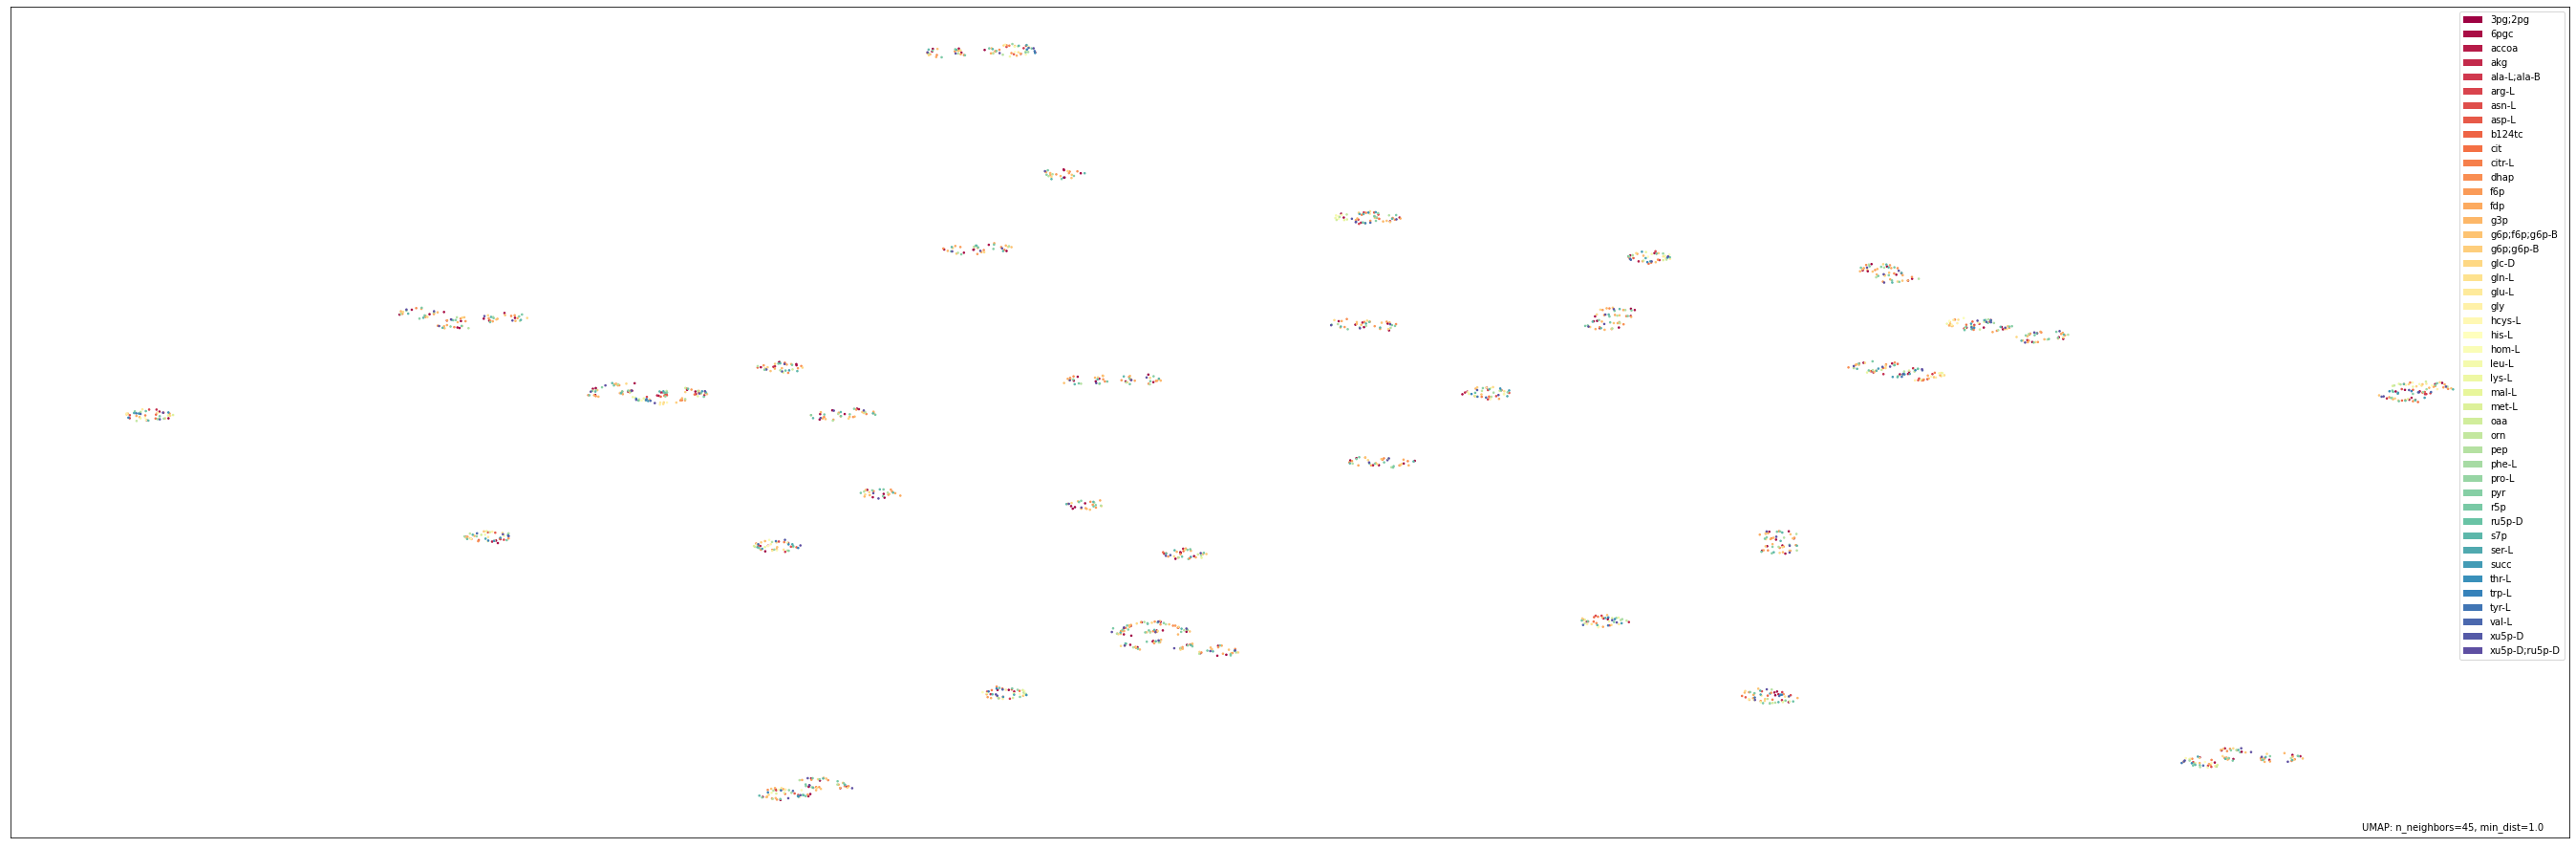

In [4]:
df = raw_proteins[
    raw_proteins["KO_ORF"].isin(raw_metabolites['genotype'])
].groupby(by=['KO_ORF', 'ORF'])['value'].mean().transform(lambda x: np.log2(x)).to_frame().pivot_table(index='KO_ORF', columns='ORF', values='value')

diff_expressed_enzymes = df.iloc[1:] - df.iloc[0]

wt_metabolites = raw_metabolites[raw_metabolites['genotype'] == 'WT']['metabolite_id'].unique()
df = raw_metabolites[
    (raw_metabolites['metabolite_id'].isin(wt_metabolites))
]

df['value'] = df['value'].transform(lambda x: np.log2(x))
df = df.pivot_table(index='genotype', columns='metabolite_id', values='value')
diff_to_wt_meta = df.iloc[1:] - df.iloc[0]
df = diff_to_wt_meta.T.unstack(1).rename('meta_change').to_frame().reset_index().merge(diff_expressed_enzymes, left_on='genotype', right_on='KO_ORF').dropna(axis=0)
targets = ['genotype', 'metabolite_id', 'meta_change']
features = df.loc[:, ~df.columns.isin(targets)]

reducer = umap.UMAP(
    n_neighbors=len(df['metabolite_id'].unique()),
    metric='euclidean',
    min_dist=1.0
)
scaler = StandardScaler()

scaled_expression = scaler.fit_transform(features.values)
embedding = reducer.fit_transform(scaled_expression)

fig, ax = plt.subplots(1, 1, figsize=(48, 16))

umap.plot.points(
    reducer,
    df['metabolite_id'],
    ax=ax
)

In [8]:
df = raw_proteins[
    raw_proteins["KO_ORF"].isin(raw_metabolites['genotype'])
].groupby(by=['KO_ORF', 'ORF'])['value'].mean().transform(lambda x: np.log2(x)).to_frame().pivot_table(index='KO_ORF', columns='ORF', values='value')

diff_expressed_enzymes = df.iloc[1:] - df.iloc[0]

wt_metabolites = raw_metabolites[raw_metabolites['genotype'] == 'WT']['metabolite_id'].unique()
df = raw_metabolites[
    (raw_metabolites['metabolite_id'].isin(wt_metabolites))
]

df['value'] = df['value'].transform(lambda x: np.log2(x))
df = df.pivot_table(index='genotype', columns='metabolite_id', values='value')
diff_to_wt_meta = df.iloc[1:] - df.iloc[0]
df = diff_to_wt_meta.T.unstack(1).rename('meta_change').to_frame().reset_index().merge(diff_expressed_enzymes, left_on='genotype', right_on='KO_ORF').dropna(axis=0)

targets = ['genotype', 'metabolite_id', 'meta_change']
features = df.loc[:, ~df.columns.isin(targets)]


def mapper(*args, **kwargs):
    df = kwargs['data']
    features = df.loc[:, ~df.columns.isin(targets)]

    reducer = umap.UMAP(
        n_neighbors=len(df['metabolite_id'].unique()),
        metric='euclidean',
        min_dist=1.0
    )

    scaled_expression = StandardScaler().fit_transform(features.values)
    reducer.fit(scaled_expression)

    umap.plot.points(
        reducer,
        df['metabolite_id'],
    )


g = sns.FacetGrid(df, col='genotype', col_wrap=4)
g.map_dataframe(mapper)


# reducer = umap.UMAP(
#     n_neighbors=len(df['metabolite_id'].unique()),
#     metric='euclidean',
#     min_dist=1.0
# )
# scaler = StandardScaler()

# embedding = reducer.fit_transform(scaled_expression)

# fig, ax = plt.subplots(1, 1, figsize=(48, 16))

# umap.plot.points(
#     reducer,
#     df['metabolite_id'],
#     ax=ax
# )

/tmp/ipykernel_320/187953377.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].transform(lambda x: np.log2(x))


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/plot.py:650: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(width / dpi, height / dpi))
/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()
()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


()


/home/tvangraft/anaconda3/envs/tf/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
